# Overview 

This notebook includes:
- SHAP explanation for image data classification
- Classification task is for an image classification problem (strawberry identification)
- Demo explaining Keras VGG16 network with Kernel SHAP
- Coding Challenge: Implement the LIME explanation for the same prediction


# ImageNet VGG16 Model with Keras

This notebook demonstrates how to use the model agnostic Kernel SHAP algorithm to explain predictions from the VGG16 network in Keras.

In [1]:
# Import required packages
import keras
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
import requests
from skimage.segmentation import slic
import matplotlib.pylab as plt
import numpy as np

import shap

### Download data

In [2]:
# Load imagenet classes on which model was trained
r = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
feature_names = r.json()

# load an image for testing
IMAGE_URL = 'https://raw.githubusercontent.com/rehmanzafar/workshop_datasets/main/apple_strawberry.jpg' 

from PIL import Image
import requests

img = Image.open(requests.get(IMAGE_URL, stream=True).raw)
img_orig = image.img_to_array(img)

# segment the image so with don't have to explain every pixel
segments_slic = slic(img, n_segments=50, compactness=30, sigma=3, start_label=1)

In [3]:
# Load VGG16 model
model = VGG16()

In [4]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

### Warning: the code below could take up to 10 minutes to run

In [5]:
# use Kernel SHAP to explain the network's predictions
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=1000, l1_reg='num_features(10)') # runs VGG16 1000 times

In [6]:
# get top predictions from the model
preds = model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

In [7]:
# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

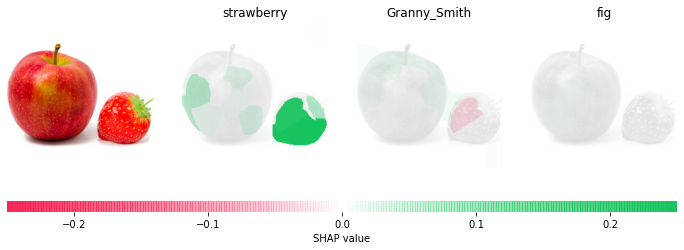

In [8]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# plot explanations
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
for i in range(3):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(feature_names[str(inds[i])][1])
    axes[i+1].imshow(img.convert('LA'), alpha=0.15)
    im = axes[i+1].imshow(m, cmap=cm, vmin=-max_val, vmax=max_val)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

## Understanding Visualization
The above cell shows four images. The first image is the originl image that is used for explanations. The rest of the images or segmented and represnts a predcited class. The second images show that the model is predicting it as a strawberry and it is filling the superpixels with green color (positive weights) that reveals that model was focusing on strawberry to make the decision.  

# Coding Challenge:
- Implement the LIME explanation for the same prediction.
- For Random Forest, obtain the global feature importance.
- Compare the feature explanations given by LIME and SHAP.
- Experiment with changing the number of iterations for SHAP explanation.